# Image Processing and Computer Vision Project

In [523]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import math
from sklearn.cluster import DBSCAN

## Step A - Multiple Product Detection

We first load the images and compute all the keypoints and the descriptors of the products and the scenes in advance

In [6]:
test_scenes = [1, 2, 3, 4, 5]
prod_images = [0, 1, 11, 19, 24, 25, 26]

dict_prod = {}
for prod in prod_images:
    # Load the product image both colour and grayscale
    img_prod = cv2.imread('models/'+str(prod)+'.jpg', cv2.IMREAD_COLOR)
    img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the product image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_p, des_p = sift.detectAndCompute(img_prod_gr, None)
    dict_prod[prod] = (img_prod, img_prod_gr, kp_p, des_p)


dict_scene = {}
for scene in test_scenes:
    # Load the scene image both colour and grayscale
    img_scene = cv2.imread('scenes/e'+str(scene)+'.png', cv2.IMREAD_COLOR)
    img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)
    
    # Sharpen the image by convolving with the sharpen kernel
    sharpen_kernel = np.array([
                [0,-1,0],
                [-1,5,-1],
                [0,-1,0]])
    img_scene_pre = cv2.filter2D(img_scene_gr,-1,sharpen_kernel)
    img_scene_pre = np.abs(img_scene_pre)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the scene image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)
    dict_scene[scene] = (img_scene, img_scene_gr, kp_s, des_s)


Then we run the matching algorithm

In [539]:
result_scene = {}
for scene in test_scenes:
    
    img_scene, img_scene_gr, kp_s, des_s = dict_scene[scene]
    
    result_prod = {}
    for prod in prod_images:
        img_prod, img_prod_gr, kp_p, des_p = dict_prod[prod]
        
        # Initializing the matching algorithm
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Matching the descriptors
        matches = flann.knnMatch(des_p,des_s,k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        # If we have at least MIN_MATCH_COUNT matches we find the box of the object
        MIN_MATCH_COUNT = 50
        if len(good)>MIN_MATCH_COUNT:
            src_pts = np.float32([ kp_p[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

            # Calculating homography based on correspondences
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # Matches mask for visualization of only matches used by RANSAC
            matchesMask = mask.ravel().tolist()

            # Apply homography to project corners of the query image into the image
            h,w = img_prod_gr.shape
            pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
            dst = cv2.perspectiveTransform(pts,M)

            # Calculate the bounding box
            x, y, w, h = cv2.boundingRect(dst)
            
            if prod in result_prod.keys():
                result_prod[prod].append(dst)
            else:
                result_prod[prod] = [dst]

        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            matchesMask = None
        
        result_scene[scene] = result_prod

Not enough matches are found - 8/50
Not enough matches are found - 19/50
Not enough matches are found - 9/50
Not enough matches are found - 5/50
Not enough matches are found - 9/50
Not enough matches are found - 18/50
Not enough matches are found - 10/50
Not enough matches are found - 12/50
Not enough matches are found - 17/50
Not enough matches are found - 14/50
Not enough matches are found - 10/50


In [33]:
kp_p[0].pt

(2.6569206714630127, 390.98797607421875)

In [32]:
kp_p[0].size, kp_s[0].size, kp_p[0].angle, kp_s[0].angle 

(2.1213436126708984, 1.9021503925323486, 100.589111328125, 293.35430908203125)

In [545]:
result_scene

{1: {0: [array([[[  7.960666 ,   1.3921112]],
   
          [[  7.5746303, 439.05753  ]],
   
          [[317.0579   , 423.53354  ]],
   
          [[318.74884  ,  -4.625615 ]]], dtype=float32)],
  1: [array([[[298.89206 , -27.152552]],
   
          [[296.10434 , 359.73322 ]],
   
          [[594.01746 , 356.24774 ]],
   
          [[592.17236 , -27.457747]]], dtype=float32)],
  11: [array([[[293.83246 , -29.12117 ]],
   
          [[293.83078 , 363.3824  ]],
   
          [[592.91754 , 359.64075 ]],
   
          [[594.23914 , -27.606508]]], dtype=float32)],
  25: [array([[[293.0576  ,   5.691082]],
   
          [[309.71576 , 419.77286 ]],
   
          [[649.2281  , 420.17908 ]],
   
          [[593.3198  ,   4.408224]]], dtype=float32)],
  26: [array([[[   8.226206,   -6.489662]],
   
          [[-105.73153 ,  784.1118  ]],
   
          [[ 428.96844 ,  703.9661  ]],
   
          [[ 313.96204 ,   -9.35757 ]]], dtype=float32)]},
 2: {0: [array([[[358.6471  , -18.852797]],
   
    

In [16]:
result_scene[1][11]

array([[[294.11624 , -28.76804 ]],

       [[294.34195 , 363.2459  ]],

       [[592.9885  , 359.9301  ]],

       [[593.49347 , -27.409767]]], dtype=float32)

In [44]:
dict_prod[0][0]

array([[[ 98, 226, 147],
        [ 98, 226, 147],
        [ 95, 226, 145],
        ...,
        [146, 240, 205],
        [154, 246, 211],
        [165, 253, 223]],

       [[ 96, 224, 145],
        [ 97, 225, 146],
        [ 94, 225, 144],
        ...,
        [146, 240, 205],
        [154, 246, 211],
        [167, 253, 223]],

       [[ 96, 224, 145],
        [ 96, 224, 145],
        [ 94, 225, 144],
        ...,
        [147, 241, 206],
        [155, 247, 212],
        [166, 252, 222]],

       ...,

       [[ 54, 247, 251],
        [ 54, 247, 251],
        [ 54, 247, 251],
        ...,
        [ 58, 249, 252],
        [ 59, 250, 253],
        [ 62, 250, 255]],

       [[ 57, 247, 252],
        [ 57, 247, 252],
        [ 56, 246, 251],
        ...,
        [ 58, 249, 252],
        [ 59, 250, 253],
        [ 63, 251, 255]],

       [[ 58, 248, 253],
        [ 57, 247, 252],
        [ 57, 247, 252],
        ...,
        [ 59, 250, 253],
        [ 59, 250, 253],
        [ 63, 249, 255]]

In [77]:
bounds = np.int32(result_scene['e1.png'][1][26])
bounds = bounds.reshape(bounds.shape[0], 2)

cv2.isContourConvex(bounds)

True

In [78]:
bounds

array([[-89,   1],
       [-95, 634],
       [350, 597],
       [340,  -9]], dtype=int32)

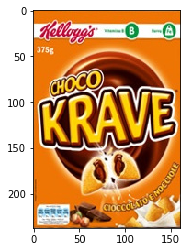

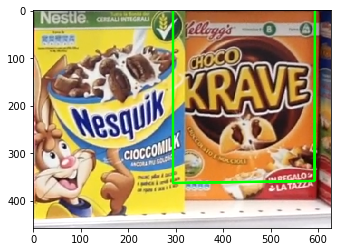

In [17]:
# Drawing bounding box
p = 11
plt.imshow(cv2.cvtColor(dict_prod[p][0],cv2.COLOR_BGR2RGB))
plt.show()
final_img = dict_scene[1][0].copy()
final_img = cv2.polylines(final_img,np.int32([result_scene[1][p]]),True,(0,255,0), 3, cv2.LINE_AA)
final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
plt.imshow(final_img_rgb)
plt.show()

In [ ]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
final_img = result_scene['e1.png'][0].copy()
img3 = cv2.drawMatches(img_query,kp_query,img_train,kp_train,good,None,**draw_params)
plt.imshow(img3, 'gray')
plt.show()

## Step B - Multiple Instance Detection

In [546]:
test_scenes = [1, 2, 3, 4, 5]
prod_images = [0, 1, 11, 19, 24, 25, 26]

dict_prod = {}
for prod in prod_images:
    # Load the product image both colour and grayscale
    img_prod = cv2.imread('models/'+str(prod)+'.jpg', cv2.IMREAD_COLOR)
    img_prod_gr = cv2.cvtColor(img_prod, cv2.COLOR_BGR2GRAY)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the product image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_p, des_p = sift.detectAndCompute(img_prod_gr, None)
    
    # Compute the barycenter for the GHT
    x = np.mean([kp.pt[0] for kp in kp_p])
    y = np.mean([kp.pt[1] for kp in kp_p])
    barycen_p = [x,y]
    
    dict_prod[prod] = (img_prod, img_prod_gr, kp_p, des_p, barycen_p)


dict_scene = {}
for scene in test_scenes:
    # Load the scene image both colour and grayscale
    img_scene = cv2.imread('scenes/m'+str(scene)+'.png', cv2.IMREAD_COLOR)
    img_scene_gr = cv2.cvtColor(img_scene, cv2.COLOR_BGR2GRAY)
    
    # Sharpen the image by convolving with the sharpen kernel
    sharpen_kernel = np.array([
                [0,-1,0],
                [-1,5,-1],
                [0,-1,0]])
    img_scene_pre = cv2.filter2D(img_scene_gr,-1,sharpen_kernel)
    img_scene_pre = np.abs(img_scene_pre)
    
    # Detecting keypoints and computing the descriptors for each keypoints in the scene image
    sift = cv2.xfeatures2d.SIFT_create()
    kp_s, des_s = sift.detectAndCompute(img_scene_pre, None)
    dict_scene[scene] = (img_scene, img_scene_gr, kp_s, des_s)


In [574]:
result_scene = {}
for scene in test_scenes:
    
    img_scene, img_scene_gr, kp_s, des_s = dict_scene[scene]
    
    result_prod = {}
    for prod in prod_images:
        img_prod, img_prod_gr, kp_p, des_p, barycen_p = dict_prod[prod]
        
        # Initializing the matching algorithm
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        search_params = dict(checks = 50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)

        # Matching the descriptors
        matches = flann.knnMatch(des_p,des_s,k=2)

        # Keeping only good matches as per Lowe's ratio test.
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        # Online phase of the GHT algorithm
        aa_quant_fact = 5
        aa_matrix = np.zeros((img_scene_gr.shape[0]//aa_quant_fact, img_scene_gr.shape[1]//aa_quant_fact))
        dict_matches = {}

        for m in good:
            # Retrieve only good matches
            kp_p_good = kp_p[m.queryIdx]
            kp_s_good = kp_s[m.trainIdx]

            # Compute the vector that connects each keypoint to the barycenter
            vec = np.subtract(barycen_p, kp_p_good.pt)

            # Scale the vector 
            vec_scaled = np.multiply(vec, kp_s_good.size/kp_p_good.size)

            # Rotate the vector
            rot_angle = math.radians(kp_s_good.angle - kp_p_good.angle)
            rot_matrix = np.array(((np.cos(rot_angle), -np.sin(rot_angle)),(np.sin(rot_angle), np.cos(rot_angle))))
            vec_scaled_rot = rot_matrix.dot(vec_scaled)

            # Calculate barycenter
            bar_x = int(round(kp_s_good.pt[0] + vec_scaled_rot[0])//aa_quant_fact)
            bar_y = int(round(kp_s_good.pt[1] + vec_scaled_rot[1])//aa_quant_fact)

            bar = (bar_x, bar_y)
            if bar in dict_matches.keys():
                dict_matches[bar].append(m)
            else:
                dict_matches[bar] = [m]

            # Cast a vote
            if 0 <= bar[0] < aa_matrix.shape[1] and 0 <= bar[1] < aa_matrix.shape[0]:
                aa_matrix[bar[1], bar[0]] += 1
            
        # Find clusters
        non_null=np.concatenate((np.nonzero(aa_matrix)[1].reshape((-1,1)), np.nonzero(aa_matrix)[0].reshape((-1,1))), axis=1)
        y = DBSCAN(eps=10, min_samples=5).fit_predict(non_null)
        cluster_labels_all = np.unique(y)
        cluster_labels = cluster_labels_all[cluster_labels_all != -1]
        n_clusters = len(cluster_labels)
        cl = []
        for i in cluster_labels:
            cl.append(non_null[y==i].tolist())

        for instance in cl:
            instance_matches = []
            for pt in instance:
                instance_matches += dict_matches[tuple(pt)]
            
            
            # If we have at least MIN_MATCH_COUNT matches we find the box of the object
            if len(instance_matches) > 30:
                src_pts = np.float32([ kp_p[m.queryIdx].pt for m in instance_matches ]).reshape(-1,1,2)
                dst_pts = np.float32([ kp_s[m.trainIdx].pt for m in instance_matches ]).reshape(-1,1,2)

                # Calculating homography based on correspondences
                M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

                # Matches mask for visualization of only matches used by RANSAC
                matchesMask = mask.ravel().tolist()

                # Apply homography to project corners of the query image into the image
                h,w = img_prod_gr.shape
                pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
                dst = cv2.perspectiveTransform(pts,M)

                # Calculate the bounding box
                x, y, w, h = cv2.boundingRect(dst)
                
                if prod in result_prod.keys():
                    result_prod[prod].append(dst)
                else:
                    result_prod[prod] = [dst]

            else:
                print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
                matchesMask = None

        result_scene[scene] = result_prod

Not enough matches are found - 75/50
Not enough matches are found - 8/50
Not enough matches are found - 375/50
Not enough matches are found - 155/50
Not enough matches are found - 64/50
Not enough matches are found - 64/50
Not enough matches are found - 53/50
Not enough matches are found - 53/50
Not enough matches are found - 73/50
Not enough matches are found - 73/50
Not enough matches are found - 11/50
Not enough matches are found - 64/50
Not enough matches are found - 147/50
Not enough matches are found - 147/50
Not enough matches are found - 73/50
Not enough matches are found - 73/50
Not enough matches are found - 223/50
Not enough matches are found - 223/50
Not enough matches are found - 223/50


In [596]:
result_scene[5]

{1: [array([[[345.36066, 516.6841 ]],
  
         [[344.36893, 929.6457 ]],
  
         [[659.94293, 921.8188 ]],
  
         [[653.64325, 515.02313]]], dtype=float32)],
 11: [array([[[  8.396672, 511.98355 ]],
  
         [[ 11.961825, 911.699   ]],
  
         [[318.5013  , 915.1326  ]],
  
         [[317.22687 , 508.76364 ]]], dtype=float32)],
 19: [array([[[ 763.7612   ,   -4.612298 ]],
  
         [[ 757.39417  ,  383.09024  ]],
  
         [[1054.1255   ,  381.84952  ]],
  
         [[1058.4065   ,    1.0860522]]], dtype=float32)],
 25: [array([[[426.55695 ,   4.285519]],
  
         [[362.8155  , 548.4262  ]],
  
         [[766.8971  , 581.01715 ]],
  
         [[718.13165 ,   8.34774 ]]], dtype=float32),
  array([[[ 88.52415  ,  -6.232187 ]],
  
         [[ 20.938087 , 549.7282   ]],
  
         [[447.65845  , 589.15247  ]],
  
         [[391.8921   ,  -0.8058273]]], dtype=float32)]}

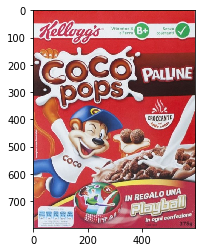

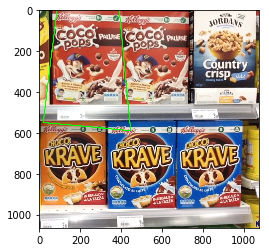

In [601]:
# Drawing bounding box
s = 5
p = 25
plt.imshow(cv2.cvtColor(dict_prod[p][0],cv2.COLOR_BGR2RGB))
plt.show()
final_img = dict_scene[s][0].copy()
final_img = cv2.polylines(final_img,np.int32([result_scene[s][p][1]]),True,(0,255,0), 3, cv2.LINE_AA)
final_img_rgb = cv2.cvtColor(final_img,cv2.COLOR_BGR2RGB)
plt.imshow(final_img_rgb)
plt.show()